# **Comparison between the qhat.py and wong.py modules**

This notebook contains a comparison between the modules `qhat.py` and `wong.py`. The `qhat.py` module computes the momentum accumulated by a highly energetic jet moving long the $\mathrm{Ox}$ axis. The `wong.py` module contains the wong_jets solver for dynamic partons moving through the Glasma. 

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 1024  
tau_sim = 2    
DTS = 2     

# Glasma
su_group = 'su3'
Qs = 2.0        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0           

# Wong
mass = 10    
tau_form = 0   
px = 50    
ntp = 10**5  
nevents = 3    
representation = 'fundamental'      
boundary = 'periodic'
initialization = 'toy'       

# Store relevant parameters in a dictionary
p = {
    'MASS': mass,           
    'PX': px,       
    }

## Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
from curraun.wong import init_pos, init_charge, init_mom_toy

# Qhat module
import curraun.qhat as qhat

import pickle
from tqdm import tqdm

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Simulation routine for evolving the Glasma & solving Wong's equations
Computes the transverse momentum variance.

In [3]:
# Simulation routine
def simulate(p, ev): 
    mass = p['MASS']
    px = p['PX']
    
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    tau = np.linspace(0, tau_sim, maxt)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('px', px / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad = np.zeros((maxt, 4))

    with tqdm(total=maxt+formt) as pbar:
        for t in range(maxt+formt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, tau

## Running the Wong solver over multiple Glasma events
This is done for various quarks and values of initial transverse momenta, afterwards perform averages and store the results to a dictionary. The masses and transverse momenta of the jets are varied around $m_\mathrm{jet}=10\,\mathrm{GeV}$ and $p_T^\mathrm{jet}=50\,\mathrm{GeV}$ chosen according to [First measurement of jet mass in Pb-Pb and p-Pb collisions at the LHC](https://arxiv.org/abs/1702.00804v2), see *Figure 11* for example.

In [4]:
pxs = [10, 20, 50, 100]
mass = 10

mom_broad, tau = {}, {}
for px in pxs:
    print('Momentum along Ox axis:', px, 'GeV')
    p['PX'] = px
    p['MASS'] = mass
    tag = 'mass_' + str(mass) + '_px_' + str(px)

    mom_broads = []
    for ev in range(nevents):
        mom_broad_ev, tau_wong = simulate(p, ev)
        mom_broads.append(mom_broad_ev)

    mom_broad[tag] = np.mean(mom_broads, axis=0)
    tau[tag] = tau_wong

output = {}
output['pxs'], output['mass'] = pxs, mass
output['mom_broad'], output['tau'] = mom_broad, tau
filename = 'mom_broad_wong_jets_px_dep.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Momentum along Ox axis: 10 GeV


Event 3: 100%|██████████| 409/409 [08:19<00:00,  1.22s/it]


Momentum along Ox axis: 20 GeV


Event 3: 100%|██████████| 409/409 [08:19<00:00,  1.22s/it]


Momentum along Ox axis: 50 GeV


Event 3:  38%|███▊      | 155/409 [03:09<05:09,  1.22s/it]

In [4]:
masses = [1, 10, 20, 50]
px = 50

mom_broad, tau = {}, {}
for mass in masses:
    print('Mass:', mass, 'GeV')
    p['PX'] = px
    p['MASS'] = mass
    tag = 'mass_' + str(mass) + '_px_' + str(px)

    mom_broads = []
    for ev in range(nevents):
        mom_broad_ev, tau_wong = simulate(p, ev)
        mom_broads.append(mom_broad_ev)

    mom_broad[tag] = np.mean(mom_broads, axis=0)
    tau[tag] = tau_wong

output = {}
output['px'], output['masses'] = px, masses
output['mom_broad'], output['tau'] = mom_broad, tau
filename = 'mom_broad_wong_jets_mass_dep.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Mass: 1 GeV


Event 3: 100%|██████████| 409/409 [08:20<00:00,  1.22s/it]


Mass: 10 GeV


Event 3: 100%|██████████| 409/409 [08:19<00:00,  1.22s/it]


Mass: 20 GeV


Event 3: 100%|██████████| 409/409 [08:19<00:00,  1.22s/it]


Mass: 50 GeV


Event 3: 100%|██████████| 409/409 [08:19<00:00,  1.22s/it]


## Simulation routine for the highly energetic jet

In [5]:
def simulate_qhat(p, ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = tau_form
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qhat_tforce = qhat.TransportedForce(s)
    mom_broad_qhat, tau_qhat =  [], []

    if use_cuda:
        qhat_tforce.copy_to_device()

    with tqdm(total=maxt+formt) as pbar:
        for t in range(maxt+formt):
            if t>=formt:  
                # Compute momentum broadening from Qhat module
                if t % DTS == 0:
                    if use_cuda:
                        qhat_tforce.copy_mean_to_host()

                    mom_broad_qhat.append(qhat_tforce.p_perp_mean * E0 ** 2)
                    tau_qhat.append((t-formt)*a/DTS)
                    
                    if use_cuda:
                        qhat_tforce.copy_mean_to_device()
                qhat_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad_qhat, tau_qhat

## Run over multiple Glasma events and do averages

In [6]:
mom_broads = []
for ev in range(nevents):
    mom_broad_ev, tau = simulate_qhat(p, ev)
    mom_broads.append(mom_broad_ev)

mom_broad = np.mean(mom_broads, axis=0)

output = {}
output['mom_broad'], output['tau'] = mom_broad, tau
filename = 'mom_broad_qhat.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 3: 100%|██████████| 409/409 [06:27<00:00,  1.06it/s]


## Read data from files using Julia

In [1]:
using Pickle

results = ["wong_jets_px_dep", "wong_jets_mass_dep", "qhat"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "mom_broad_" * r * ".pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname("mom_broad_" * r,  data["mom_broad"])
    string_as_varname("tau_" * r,  data["tau"])
end

pxs, mass = string.(data_wong_jets_px_dep["pxs"]), string.(data_wong_jets_px_dep["mass"])
masses, px = string.(data_wong_jets_mass_dep["masses"]), string.(data_wong_jets_mass_dep["px"])

(["1", "10", "20", "50"], "50")

## Plot the results using Makie from Julia

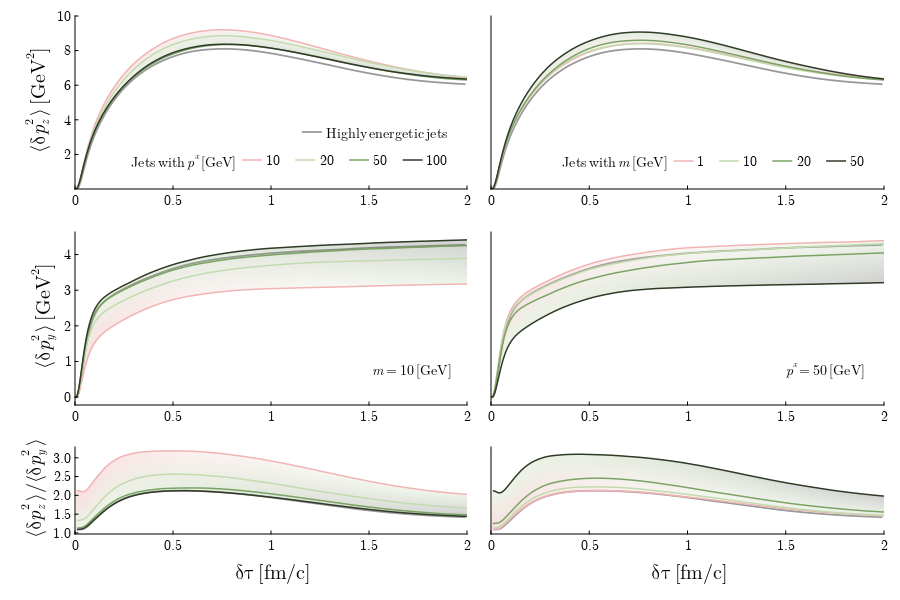

In [3]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:watermelon, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (900, 600), font = "CMU Serif")
ylabels = [L"\langle\delta p_z^2\,\rangle\,\mathrm{[GeV^2]}", L"\langle\delta p_y^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_z\,\rangle/\langle\delta p^2_y\,\rangle"]
axes = [[Axis(fig[i, j], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for i in 1:3] for j in 1:2]

for i in 1:2
        δτ_qhat = Float64.(tau_qhat)
        mom_broad_L_qhat = mom_broad_qhat[:, 3]
        lines!(axes[i][1], δτ_qhat, mom_broad_L_qhat, linewidth = 1.8, color=:grey60)
        # mom_broad_T_qhat = mom_broad_qhat[:, 1] + mom_broad_qhat[:, 2] 
        mom_broad_T_qhat = mom_broad_qhat[:, 2] 
        # mom_broad_T_qhat = mom_broad_qhat[:, 1]
        lines!(axes[i][2], δτ_qhat, mom_broad_T_qhat, linewidth = 1.8, color=:grey60)
        ratio = mom_broad_L_qhat./mom_broad_T_qhat
        global qhat = lines!(axes[i][3], δτ_qhat, ratio, linewidth = 1.8, color=:grey60)
end

# px dependence 
tag_low, tag_high = "mass_" * mass * "_px_" * pxs[1], "mass_" * mass * "_px_" * pxs[length(pxs)]
δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_low])
mom_broad_L_low, mom_broad_L_high = mom_broad_wong_jets_px_dep[tag_low][:, 3] , mom_broad_wong_jets_px_dep[tag_high][:, 3]
band!(axes[1][1], δτ_wong_jets, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.2))
# mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_px_dep[tag_low][:, 1] + mom_broad_wong_jets_px_dep[tag_low][:, 2], mom_broad_wong_jets_px_dep[tag_high][:, 1] + mom_broad_wong_jets_px_dep[tag_high][:, 2]
mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_px_dep[tag_low][:, 2], mom_broad_wong_jets_px_dep[tag_high][:, 2]
# mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_px_dep[tag_low][:, 1], mom_broad_wong_jets_px_dep[tag_high][:, 1]
band!(axes[1][2], δτ_wong_jets, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.2))
ratio_low, ratio_high = mom_broad_L_low./mom_broad_T_low, mom_broad_L_high./mom_broad_T_high
band!(axes[1][3], δτ_wong_jets, ratio_low, ratio_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.2))

for ip in 1:length(pxs)
        tag_wong_jets = "mass_" * mass * "_px_" * pxs[ip]
        δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_wong_jets])

        mom_broad_L_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 3]
        lines!(axes[1][1], δτ_wong_jets, mom_broad_L_wong_jets, linewidth = 1.5, color=colors[ip])
        # mom_broad_T_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 1] + mom_broad_wong_jets_px_dep[tag_wong_jets][:, 2]
        mom_broad_T_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 2]
        # mom_broad_T_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 1]
        lines!(axes[1][2], δτ_wong_jets, mom_broad_T_wong_jets, linewidth = 1.5, color=colors[ip])
        ratio = mom_broad_L_wong_jets./mom_broad_T_wong_jets
        string_as_varname("wong_px_"*string(ip), lines!(axes[1][3], δτ_wong_jets, ratio, linewidth = 1.5, color=colors[ip]))
end

# mass dependence
tag_low, tag_high = "mass_" * masses[1] * "_px_" * px, "mass_" * masses[length(masses)] * "_px_" * px
δτ_wong_jets = Float64.(tau_wong_jets_mass_dep[tag_low])
mom_broad_L_low, mom_broad_L_high = mom_broad_wong_jets_mass_dep[tag_low][:, 3] , mom_broad_wong_jets_mass_dep[tag_high][:, 3]
band!(axes[2][1], δτ_wong_jets, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.2))
# mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_mass_dep[tag_low][:, 1] + mom_broad_wong_jets_mass_dep[tag_low][:, 2], mom_broad_wong_jets_mass_dep[tag_high][:, 1] + mom_broad_wong_jets_mass_dep[tag_high][:, 2]
mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_mass_dep[tag_low][:, 2], mom_broad_wong_jets_mass_dep[tag_high][:, 2]
# mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_mass_dep[tag_low][:, 1], mom_broad_wong_jets_mass_dep[tag_high][:, 1]
band!(axes[2][2], δτ_wong_jets, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.2))
ratio_low, ratio_high = mom_broad_L_low./mom_broad_T_low, mom_broad_L_high./mom_broad_T_high
band!(axes[2][3], δτ_wong_jets, ratio_low, ratio_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.2))

for im in 1:length(masses)
        tag_wong_jets = "mass_" * masses[im] * "_px_" * px
        δτ_wong_jets = Float64.(tau_wong_jets_mass_dep[tag_wong_jets])

        mom_broad_L_wong_jets = mom_broad_wong_jets_mass_dep[tag_wong_jets][:, 3]
        lines!(axes[2][1], δτ_wong_jets, mom_broad_L_wong_jets, linewidth = 1.5, color=colors[im])
        # mom_broad_T_wong_jets = mom_broad_wong_jets_mass_dep[tag_wong_jets][:, 1] + mom_broad_wong_jets_mass_dep[tag_wong_jets][:, 2]
        mom_broad_T_wong_jets = mom_broad_wong_jets_mass_dep[tag_wong_jets][:, 2]
        # mom_broad_T_wong_jets = mom_broad_wong_jets_mass_dep[tag_wong_jets][:, 1]
        lines!(axes[2][2], δτ_wong_jets, mom_broad_T_wong_jets, linewidth = 1.5, color=colors[im])
        ratio = mom_broad_L_wong_jets./mom_broad_T_wong_jets
        string_as_varname("wong_mass_"*string(im), lines!(axes[2][3], δτ_wong_jets, ratio, linewidth = 1.5, color=colors[im]))
end


for i in 1:3
        linkyaxes!(axes[1][i], axes[2][i])
        hideydecorations!(axes[2][i], grid = false)
        for j in 1:2
                xlims!(axes[j][i], 0, 2)
                axes[j][i].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:2
        linkxaxes!(axes[j][1], axes[j][2], axes[j][3])
        hidexdecorations!(axes[j][1], ticks = false, ticklabels = false)
        hidexdecorations!(axes[j][2], ticks = false, ticklabels = false)
end

ylims!(axes[1][1], 0, 10)
axes[1][1].yticks = ([2, 4, 6, 8, 10], string.([2, 4, 6, 8, 10]))
# ylims!(axes[2][2], 0, 8)
# axes[1][2].yticks = ([2, 4, 6, 8], string.([2, 4, 6, 8]))
# ylims!(axes[1][3], 0.7, 2.2)
# axes[1][3].yticks = ([1, 2], string.([1, 2]))

rowsize!(fig.layout, 1, Relative(2/5))
rowsize!(fig.layout, 2, Relative(2/5))
rowsize!(fig.layout, 3, Relative(1/5))

legend_wong_px = pxs
axislegend(axes[1][1], [wong_px_1, wong_px_2, wong_px_3, wong_px_4], legend_wong_px, L"\mathrm{Jets\,with\,}p^x\,\mathrm{[GeV]}", labelsize=14, 
        titleposition = :left, titlesize=14, position = (1,0), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_wong_mass = masses
axislegend(axes[2][1], [wong_mass_1, wong_mass_2, wong_mass_3, wong_mass_4], legend_wong_mass, L"\mathrm{Jets\,with\,}m\,\mathrm{[GeV]}", labelsize=14, 
        titleposition = :left, titlesize=14, position = (1,0), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_qhat = [L"\mathrm{Highly\,energetic\,jets}"]
axislegend(axes[1][1], [qhat], legend_qhat, labelsize=14, position = (1,0.25), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][2], L"m=10\,\mathrm{[GeV]}", position = (1.52,0.5), textsize=14)
text!(axes[2][2], L"p^x=50\,\mathrm{[GeV]}", position = (1.5,0.5), textsize=14)


display(fig)
# save("makie_mom_broad_wong_vs_qhat.png", fig, px_per_unit = 5.0) 